## Read Data

In [1]:
hs_data=[[19.52 ,71.19 ,75.03 ],
        [19.52 ,71.52 ,75.29 ],
        [19.52 ,71.16 ,74.96 ],
        [19.52 ,71.19 ,75.03 ],
        [19.60 ,71.32 ,75.31 ],
        [19.49 ,71.00 ,74.46 ],
        [19.60 ,71.32 ,75.31 ],
        [19.60 ,71.32 ,75.31 ],
        [19.52 ,71.16 ,74.96 ],
        [19.52 ,71.19 ,75.03 ]]

euconst_data = [[52.04,45.27,71.37],
                [52.04,45.27,71.37],
                [52.04 ,45.27 ,71.37],
                [52.04 ,45.27 ,71.37],
                [52.04 ,45.27 ,71.37 ],
                [52.04 ,45.27 ,71.37 ],
                [52.04 ,45.27 ,71.37],
                [52.16 ,45.09 ,71.03],
                [53.28 ,47.01 ,72.30],
                [52.04 ,45.27 ,71.37]]

samsum_data = [[35.79,13.54,28.76 ],
                [35.69,13.73,28.70 ],
                [35.75,13.46,28.72 ],
                [35.71,13.43,28.54], 
                [35.76,13.59,28.70], 
                [35.98,13.79,28.75], 
                [35.84,13.47,28.72], 
                [35.44,13.28,28.40], 
                [35.94,13.68,28.75], 
                [35.79,13.64,28.98] ]

## Plot Graph

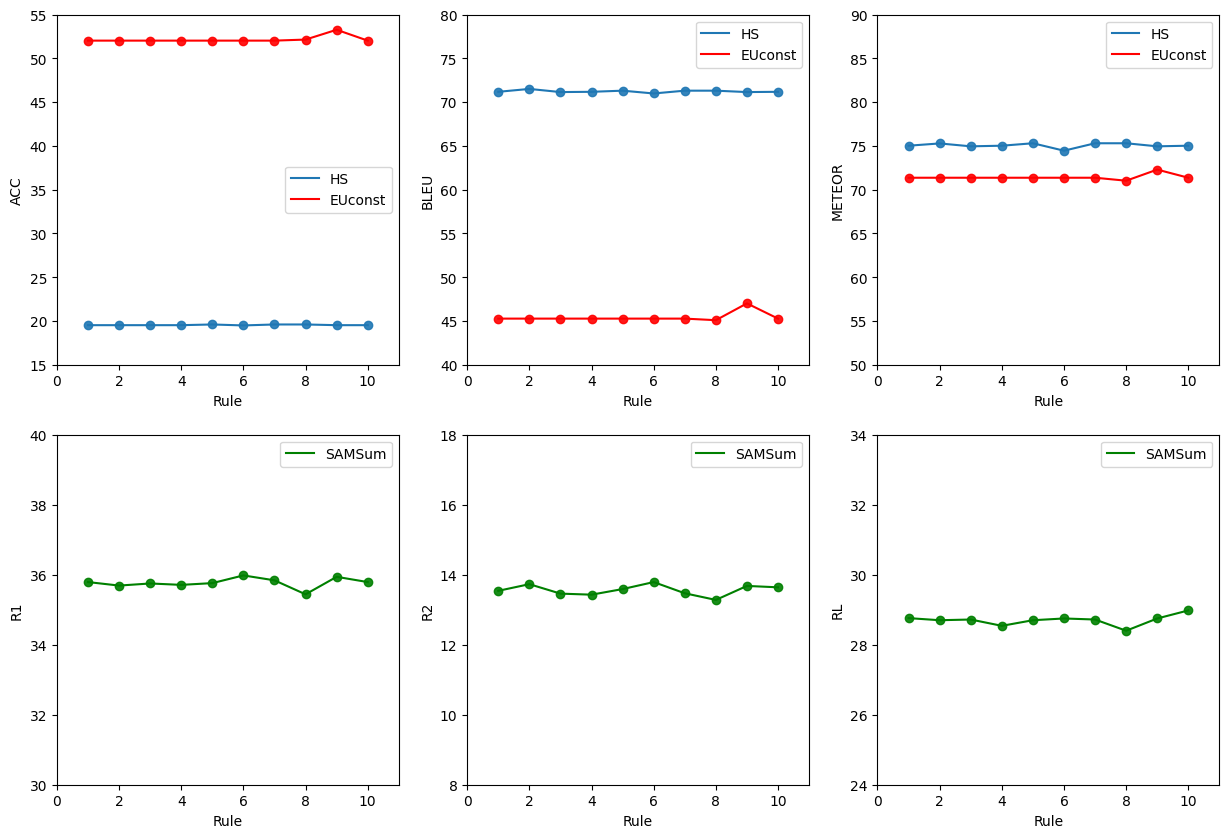

In [4]:
from matplotlib import pyplot as plt
import numpy as np

rule_data = np.arange(1, 11, 1)
hs_data = np.array(hs_data)
euconst_data = np.array(euconst_data)
samsum_data = np.array(samsum_data)

f, axes = plt.subplots(2, 3, figsize=(15,10))

sub_graph = axes[0][0]
sub_graph.plot(rule_data, hs_data[:, 0], label='HS')
sub_graph.scatter(rule_data, hs_data[:, 0], alpha=.9)
sub_graph.plot(rule_data, euconst_data[:, 0], label='EUconst', color='r')
sub_graph.scatter(rule_data, euconst_data[:, 0], alpha=.9, color='r')
# sub_graph.set_title("HS(FuzzyS2S-T)")
sub_graph.set_xlabel("Rule")
sub_graph.set_ylabel("ACC")
sub_graph.set_xlim(0,11)
sub_graph.set_ylim(15,55)
sub_graph.legend()

sub_graph = axes[0][1]
sub_graph.plot(rule_data, hs_data[:, 1], label='HS')
sub_graph.scatter(rule_data, hs_data[:, 1], alpha=.9)
sub_graph.plot(rule_data, euconst_data[:, 1], label='EUconst', color='r')
sub_graph.scatter(rule_data, euconst_data[:, 1], alpha=.9, color='r')
# sub_graph.set_title("HS(FuzzyS2S-T)")
sub_graph.set_xlabel("Rule")
sub_graph.set_ylabel("BLEU")
sub_graph.set_xlim(0,11)
sub_graph.set_ylim(40,80)
sub_graph.legend()

sub_graph = axes[0][2]
sub_graph.plot(rule_data, hs_data[:, 2], label='HS')
sub_graph.scatter(rule_data, hs_data[:, 2], alpha=.9)
sub_graph.plot(rule_data, euconst_data[:, 2], label='EUconst', color='r')
sub_graph.scatter(rule_data, euconst_data[:, 2], alpha=.9, color='r')
# sub_graph.set_title("SamSum(FuzzyS2S-T)")
sub_graph.set_xlabel("Rule")
sub_graph.set_ylabel("METEOR")
sub_graph.set_xlim(0,11)
sub_graph.set_ylim(50,90)
sub_graph.legend()

sub_graph = axes[1][0]
data = samsum_data
sub_graph.plot(rule_data, data[:, 0], label='SAMSum',color='g')
sub_graph.scatter(rule_data, data[:, 0], alpha=.9, color='g')
# sub_graph.set_title("EUconst(FuzzyS2S-T)")
sub_graph.set_xlabel("Rule")
sub_graph.set_ylabel("R1")
sub_graph.set_xlim(0,11)
sub_graph.set_ylim(30,40)
sub_graph.legend()

sub_graph = axes[1][1]
data = samsum_data
sub_graph.plot(rule_data, data[:, 1], label='SAMSum',color='g')
sub_graph.scatter(rule_data, data[:, 1], alpha=.9, color='g')
# sub_graph.set_title("HS(FuzzyS2S-T)")
sub_graph.set_xlabel("Rule")
sub_graph.set_ylabel("R2")
sub_graph.set_xlim(0,11)
sub_graph.set_ylim(8,18)
sub_graph.legend()

sub_graph = axes[1][2]
data = samsum_data
sub_graph.plot(rule_data, data[:, 2], label='SAMSum',color='g')
sub_graph.scatter(rule_data, data[:, 2], alpha=.9, color='g')
# sub_graph.set_title("SamSum(FuzzyS2S-T)")
sub_graph.set_xlabel("Rule")
sub_graph.set_ylabel("RL")
sub_graph.set_xlim(0,11)
sub_graph.set_ylim(24,34)
sub_graph.legend()